# Projet Séries Chronologiques : Ventes d'une boutique

## Données 

 Ensemble de données de vente au détail d'un supermarché mondial pendant 4 ans. (Kaggle)

Importation des packages

In [405]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
import torch
from jyquickhelper import add_notebook_menu
add_notebook_menu()
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = 18,8
pd.set_option('display.max_columns', None)


from sklearn.metrics import mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


Récupérons les données

In [406]:
df = pd.read_csv('data/data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

On souhaite représenter seulement les ventes au fil du temps.

In [407]:

df = df[['Order Date','Sales']]
df.rename(columns={'Order Date' : 'Date'},inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df.Date,inplace = True)
df.drop('Date',axis=1,inplace = True)
display(df)



,Sales
Date,
2017-08-11,261.9600
2017-08-11,731.9400
2017-12-06,14.6200
2016-11-10,957.5775
2016-11-10,22.3680
...,...
2017-05-21,3.7980
2016-12-01,10.3680
2016-12-01,235.1880


On retrouve 9800 observations.

Vérifions si nous avons des données manquantes dans notre série temporelle, si c'est le cas notre série temporelle ne fonctionnera pas.

In [408]:
df.isna().sum()

Sales    0
dtype: int64

Il n'y a pas de données manquantes.

In [409]:
df.describe()


,Sales
count,9800.000000
mean,230.769059
std,626.651875
min,0.444000
25%,17.248000
50%,54.490000
75%,210.605000
max,22638.480000


# IQR
Q1 = np.percentile(df['Sales'], 25,interpolation = 'midpoint')
 
Q3 = np.percentile(df['Sales'], 75,interpolation = 'midpoint')
IQR = Q3 - Q1
 
 
# Upper bound
upper = np.where(df['Sales'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['Sales'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''

df.drop(df.iloc[upper[0]].index, inplace = True,axis=0)
df.drop(df.iloc[lower[0]].index, inplace = True,axis=0)
 
print("New Shape: ", df.shape)

On constate que les ventes possèdent des valeurs aberrantes.

In [274]:
df.describe()


,Sales
count,5285.000000
mean,132.799506
std,187.342843
min,0.444000
25%,15.570000
50%,47.616000
75%,167.292000
max,917.923500


In [280]:
data=df.copy()
data.sort_values(by=['Date'])
data.shape

(9800, 1)

Comme les données sont collectées pour chaque commande, on calcule la moyenne des commandes par mois.

In [410]:

df = df.resample('M').mean()
display(df)

,Sales
Date,
2015-01-31,228.795667
2015-02-28,149.862905
2015-03-31,335.575727
2015-04-30,204.215008
2015-05-31,202.195137
2015-06-30,216.158034
2015-07-31,228.536091
2015-08-31,257.581141
2015-09-30,277.127730


## Analyse descriptive

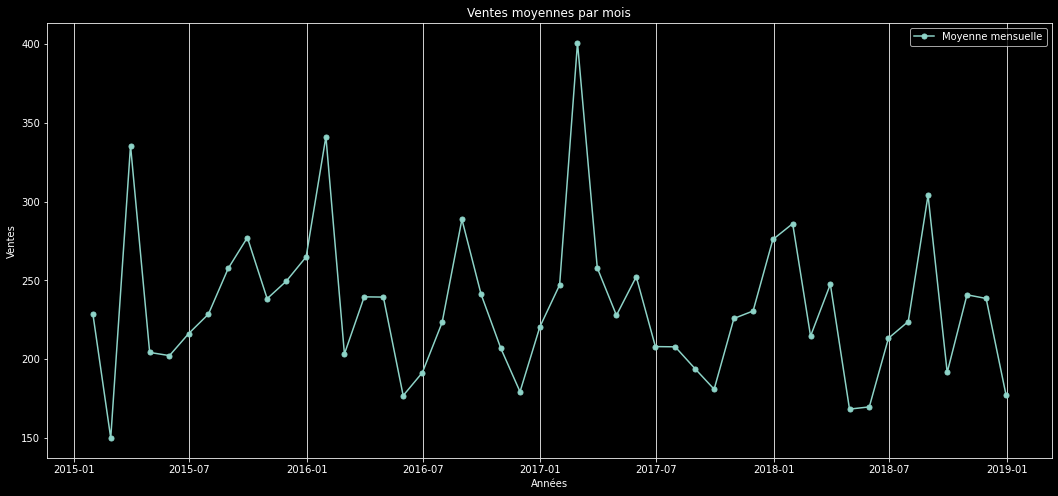

In [411]:
y = df['Sales']
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(y,marker = 'o',markersize='5',linestyle='-',label = 'Moyenne mensuelle')
ax.set_xlabel('Années')
ax.set_ylabel('Ventes')
ax.set_title('Ventes moyennes par mois')
ax.grid(axis='x')
ax.legend();

On considère que l'on a une série temporelle suivant un modèle additif.

Afin d'avoir un aperçu plus complet de notre série temporelle, nous allons la série de façon à avoir :
-Observations (série actuelle)
-Tendance
-Saisonalité
-Résidus

On choisi le modèle additif au lieu de multiplicatif car il n'y a pas d'augmentation exponentielle des ventes au fil du temps

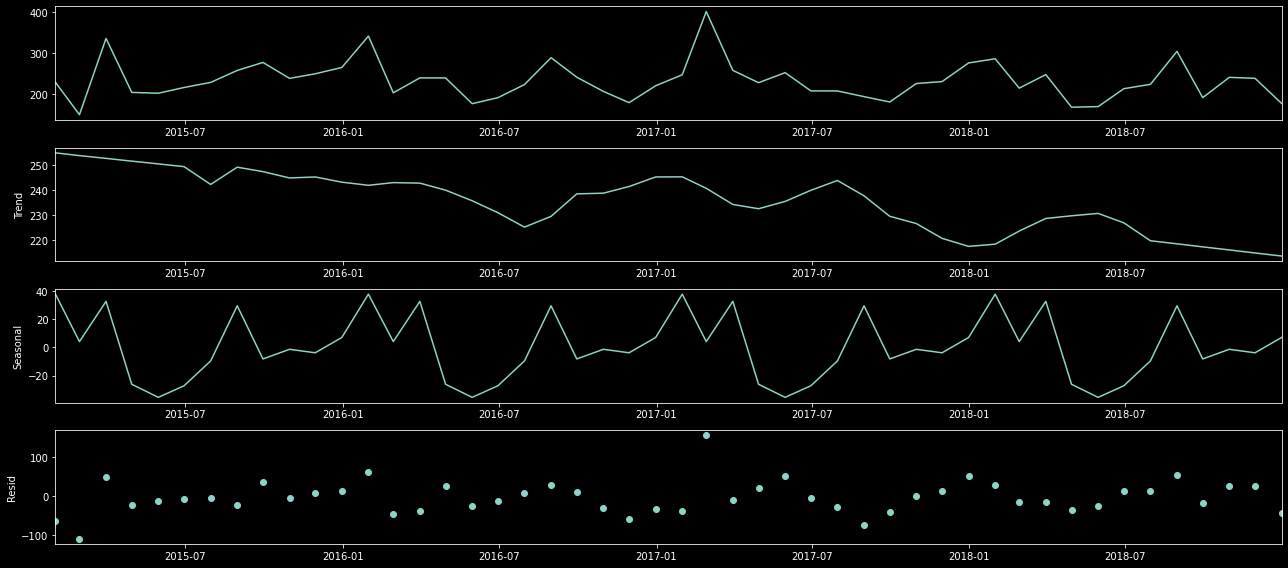

In [412]:
df_dec=seasonal_decompose(df,model='additive', extrapolate_trend='freq')
df_dec.plot();

On voit que notre série à une tendance descendante et qu'il y a bien une saisonalité.
C'est pourquoi, on pourra utiliser cette série temporelle afin de prédire les futures observations.


Stationnarité

Maintenant, nous devons vérifier si la série est stationnaire. C'est le cas si :
-La moyenne est constante
-La variance est constante

Si ce n'est pas le cas, nous devons rendre la série stationnaire afin d'utiliser des modèles prédictifs sur cette série.

Nous allons utiliser deux méthodes afin de vérifier la stationnarité :
-Visualisation graphique
-Test augmenté de Dickey-Fuller (Test ADF)

Visualisation

In [416]:
sales_mean = df.Sales.rolling(15).mean().dropna()
sales_std = df.Sales.rolling(15).std().dropna()

In [417]:
df.Sales.rolling(10).mean().dropna()

Date
2015-10-31    233.840570
2015-11-30    235.910405
2015-12-31    247.410910
2016-01-31    247.978205
2016-02-29    247.878618
2016-03-31    251.610270
2016-04-30    253.929667
2016-05-31    248.755114
2016-06-30    242.135193
2016-07-31    236.745319
2016-08-31    241.778276
2016-09-30    240.944371
2016-10-31    235.132012
2016-11-30    218.931569
2016-12-31    220.647940
2017-01-31    221.403388
2017-02-28    237.556376
2017-03-31    245.661604
2017-04-30    249.301931
2017-05-31    252.207146
2017-06-30    244.129853
2017-07-31    240.791442
2017-08-31    239.509723
2017-09-30    239.670768
2017-10-31    240.211253
2017-11-30    238.557608
2017-12-31    226.063012
2018-01-31    228.875422
2018-02-28    227.556916
2018-03-31    227.080002
2018-04-30    223.110386
2018-05-31    219.296971
2018-06-30    221.228275
2018-07-31    225.525700
2018-08-31    233.353698
2018-09-30    229.450825
2018-10-31    225.938542
2018-11-30    221.189446
2018-12-31    217.473742
Freq: M, Name: Sales

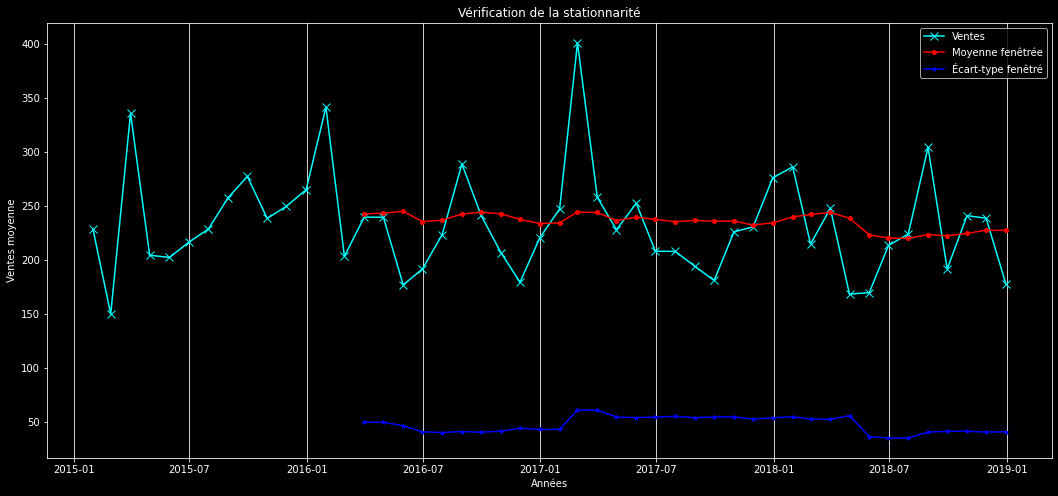

In [418]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df.Sales,marker = 'x',markersize = 8 , label = 'Ventes', color = 'cyan')
ax.plot(sales_mean,marker= 'o', markersize = 4, label = 'Moyenne fenêtrée', color = 'red');
ax.plot(sales_std,marker = '*', markersize = 4, label = 'Écart-type fenêtré',color ='blue');
ax.legend()
plt.xlabel('Années')
plt.ylabel('Ventes moyenne') 
plt.title('Vérification de la stationnarité')
ax.grid(axis = 'x')

Après lissage de notre série, on constate que la moyenne et l'écart-type à l'air constant.
Cependant, nous ne pouvons pas conclure seulement avec une visualisation. 
Nous allons effectuer le test augmenté de Dickey-Fuller afin de confirmer la stationnarité de la série.

ADF test

Le test augmenté de Dickey-Fuller est un test statistique qui est utilisé pour vérifier la staionnarité d'une série temporelle.
Ce test retourne une p-value, une valeur de test statistique, et les valeurs critiques avec intervalles de confiance.
Selon la p-value obtenue, nous pourrons rejeter ou accepter l'hypothèse nulle.

$H_0$ : 'La série n'est pas stationnaire' $\\$
$H_1$ : 'La série est stationnaire'


Si la p-value est supérieur à 0.05, alors on ne peut pas rejeter $H_0$, la série n'est pas stationnaire. $\\$
Si la p-value est inférieur ou égale à 0.05, alors on rejète $H_0$, la série est stationnaire.


Plus la valeur du test statistique est négatif, plus nous avons tendance à rejeter l'hypothèse $H_0$

In [419]:
dftest = adfuller(df,autolag='AIC')
print('Valeur de test statistique : {:.3f}'.format(dftest[0]))
print('P-value : {}'.format(dftest[1]))
for key, value in dftest[4].items():
	print('\t%s: %.3f' % (key, value))

Valeur de test statistique : -6.150
P-value : 7.621085098966013e-08
	1%: -3.578
	5%: -2.925
	10%: -2.601


Notre valeur de test statistique est de -6.150 ce qui est inférieur à la valeur critique à 1%. $\\$
Cela signifie que l'on peut rejeter $H_0$ au niveau $\alpha$ = 0.01


On peut conclure avec confiance que la série est stationnaire

In [420]:
from pmdarima.arima.utils import ndiffs
ndiffs(df,test='adf')

0

Cette fonction permet de confirmer le fait que l'on a pas besoin de différencier notre série pour la rendre stationnaire

Création d'un modèle de prédiction

Puisque notre série est stationnaire, nous pouvons crée un modèle prédictif. 

Débutons par le modèle naif qui consiste à prédire selon la même observation que le mois dernier.

## Prédiction

### Modèle naîf 

In [423]:
df['shifted_sales'] = df.Sales.shift(1)

In [424]:
df.head(4)

,Sales,shifted_sales
Date,,
2015-01-31,228.795667,NaN
2015-02-28,149.862905,228.795667
2015-03-31,335.575727,149.862905
2015-04-30,204.215008,335.575727


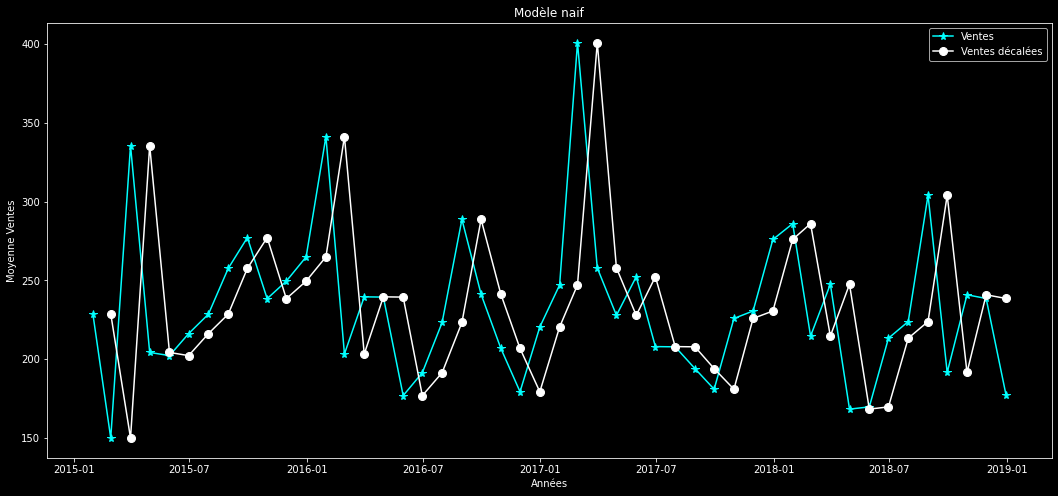

In [425]:
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df.Sales, marker ="*", markersize = 8 , label = 'Ventes' , color ='cyan')
ax.plot(df.shifted_sales, marker = 'o', markersize = 8, label = 'Ventes décalées',color = 'white')
plt.xlabel('Années')
plt.ylabel('Moyenne Ventes')
plt.title('Modèle naif')
ax.legend()
plt.show()

In [426]:
df = df.dropna()

In [427]:
mse = mean_squared_error(df.Sales,df.shifted_sales)
rsme = np.sqrt(mse)

print(f"La racine de l'erreur quadratique moyenne du modèle naif est de : {rsme}")

La racine de l'erreur quadratique moyenne du modèle naif est de : 64.50443442745502


On a une RSME de 65, ce qui signifie qu'en moyenne la prédictions des ventes différe de plus ou moins **65** par rapport à la valeur réelle. 

###  Holt-Winters

Testons maintenant le modèle additif de Holt-Winters pour prédire.

In [428]:
df.drop('shifted_sales',axis=1,inplace=True)

In [429]:
holt_winters = ExponentialSmoothing(df,seasonal_periods=12,trend='add',seasonal='add').fit() 
holt_winters_pred = holt_winters.forecast(steps=24)

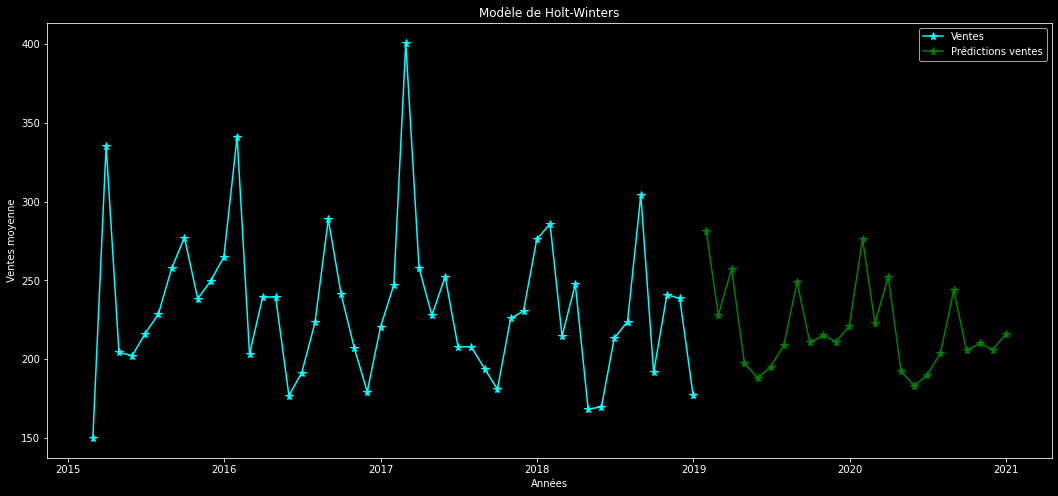

In [430]:
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(df,marker = '*',markersize = 8, label = 'Ventes', color = 'cyan')
ax.plot(holt_winters_pred,marker = '*',markersize = 8, label = 'Prédictions ventes',color = 'green');
plt.xlabel('Années')
plt.ylabel('Ventes moyenne')
plt.title('Modèle de Holt-Winters')
ax.legend()
plt.show()


In [431]:
holt_winters_error = holt_winters.resid
holt_winters_error_sqr = np.square(holt_winters_error)
holt_winters_error_mse = holt_winters_error_sqr.sum()/len(holt_winters_error_sqr)
holt_winters_error_rsme = np.sqrt(holt_winters_error_mse)

print(f'Le modèle de Holt-Winters a une RSME de : {holt_winters_error_rsme}')

Le modèle de Holt-Winters a une RSME de : 40.14449414637247


On constate que ce modèle prédit mieux que le modèle naif avec une RSME inférieur.

Nous allons maintenant utiliser le modèle SARIMA pour prédire. 


### SARIMA

On utilise le modèle SARIMA au lieu du ARIMA étant donné que notre série admet une saisonnalité.

Le modèle SARIMA est caractérisé par trois variables **p,q,d**. $\\$
p est l'ordre du terme auto-régressif $\\$
q est l'odre du terme à moyenne mobile $\\$
d est le nombre de différences nécessaire pour rendre la série stationnaire.

Ces variables sont à déterminer afin de les donner au modèle ARIMA. $\\$
Nous avons vu précédemment grâce au test de Dickey-Fuller augmenté que la série est stationnaire. $\\$
Donc, **d=0**. $\\$
Il nous reste à déterminer **p** et **q**.

Déterminons ces termes en utilisant le graphique d'autocorrélation (ACF) et le graphique d'autocorrélation partielle (PACF).

Le graphique d'autocorrélation nous permet de trouver la valeur du processus auto-régressif.

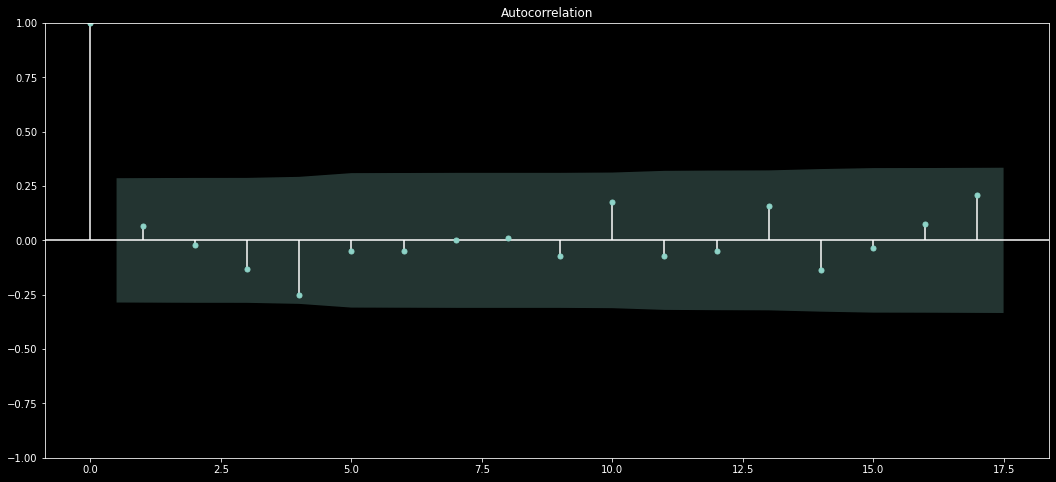

In [432]:
plot_acf(df);

La zone coloriée corrrespond à l'intervalle de confiance. On retrouve une valeur en dehors de l'intervalle de confiance. $\\$$
On a donc **p=1**

Le graphique d'autocorrélation partielle nous permet de trouver la valeur du processus à moyenne mobile.

/home/etudiant/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



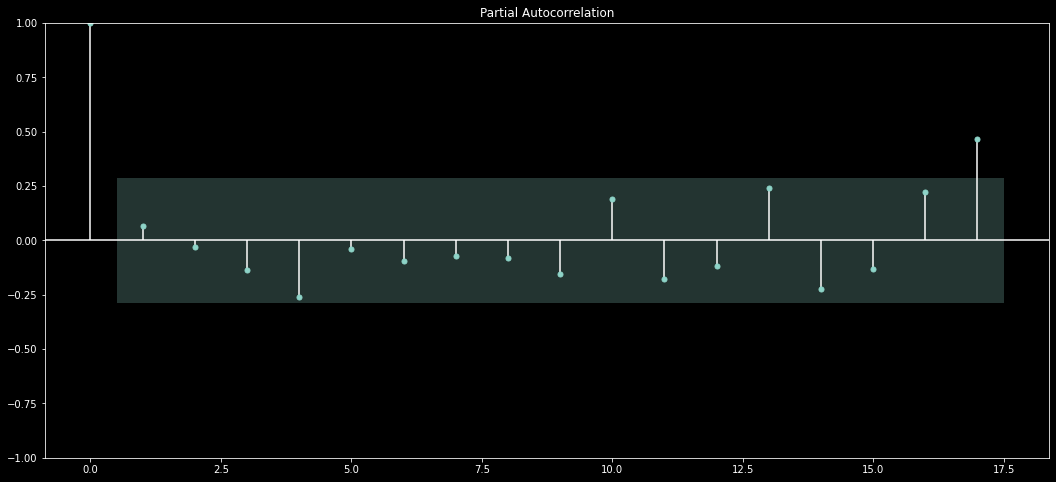

In [433]:
plot_pacf(df);

Il existe au corrélation significative au niveau du décalage 1.
Ceci indique  que les autocorrélations de décalage supérieur à 1 ne sont dues qu'à la propagation de l'autocorrélation de décalage 1. On a **q=1**.

In [435]:
dftrain = df.iloc[:38]
dftest = df.iloc[38:]



In [436]:
dftest

,Sales
Date,
2018-04-30,168.218736
2018-05-31,169.636707
2018-06-30,213.240216
2018-07-31,223.828944
2018-08-31,304.067677
2018-09-30,191.500953
2018-10-31,240.813096
2018-11-30,238.475989
2018-12-31,177.443102


In [437]:
p=4
q=4
d=0
arima_model = ARIMA(dftrain,order = (p,d,q))
arima_model = arima_model.fit()
arima_pred = arima_model.forecast(steps=9)

/home/etudiant/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/etudiant/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [438]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -196.052
Date:                Wed, 19 Jan 2022   AIC                            412.103
Time:                        14:57:53   BIC                            428.479
Sample:                    02-28-2015   HQIC                           417.930
                         - 03-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        238.0695      2.710     87.846      0.000     232.758     243.381
ar.L1         -0.2294      0.319     -0.719      0.472      -0.854       0.396
ar.L2         -0.1079      0.301     -0.359      0.720      -0.698       0.482
ar.L3         -0.2340      0.314     -0.746      0.456      -0.849       0.381
ar.L4          0.3514      0.404      0.869      0.385      -0.441       1.144
ma.L1          0.0962    126.921      0.001      0.999    -248.665     248.858
ma.L2          0.0045    253.144   1.79e-05      1.000    -496.149     496.158
ma.L3         -0.1062    126.351     -0.001      0.999    -247.750     247.537
ma.L4         -0.9946      0.362     -2.748      0.006      -1.704      -0.285
sigma2      1495.2783      0.363   4114.637      0.000    1494.566    1495.991
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.98
Prob(Q):                              0.90   Prob(JB):                         0.22
Heteroskedasticity (H):               0.31   Skew:                             0.66
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.93e+21. Standard errors may be unstable.
"""

In [439]:
arima_pred

2018-04-30    231.489233
2018-05-31    234.728195
2018-06-30    251.512432
2018-07-31    243.552707
2018-08-31    233.831296
2018-09-30    234.130050
2018-10-31    242.870608
2018-11-30    240.311742
2018-12-31    236.469971
Freq: M, Name: predicted_mean, dtype: float64

In [440]:
mse = mean_squared_error(dftest, arima_pred)
rmse = np.sqrt(mse)
print(f"La racine de l'erreur moyenne au carré d'ARIMA(1,1,0) is de {rmse}")

La racine de l'erreur moyenne au carré d'ARIMA(1,1,0) is de 47.53479529244031


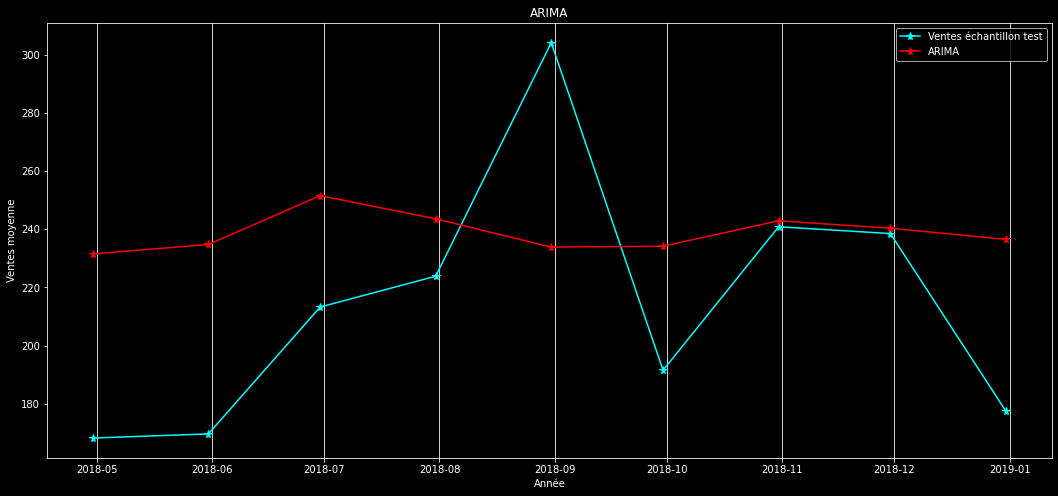

In [441]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(dftest,marker='*', markersize=8, label='Ventes échantillon test', color='cyan');
ax.plot(arima_pred,marker='*', markersize=8, label='ARIMA', color='red');
plt.xlabel('Année')
plt.ylabel('Ventes moyenne')
plt.title('ARIMA' )
ax.grid(axis='x')
ax.legend()
plt.show()

### Réseau de neurones


#### Rappel sur les réseaux de neurones

#### Réseau de neuronnes récursifs

#### Réseau de neurones LSTM

#### Application

In [442]:
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import  Bidirectional

In [443]:
data=data.sort_values(by=['Date'])
data_m = data.resample('M').mean()
data_m = data_m.dropna()
data_m['time']=data_m.index
data_m.set_index(['time'],inplace=True)
data_m.sort_index(inplace=True)
display(data_m)


,Sales
time,
2015-01-31,228.795667
2015-02-28,149.862905
2015-03-31,335.575727
2015-04-30,204.215008
2015-05-31,202.195137
2015-06-30,216.158034
2015-07-31,228.536091
2015-08-31,257.581141
2015-09-30,277.127730


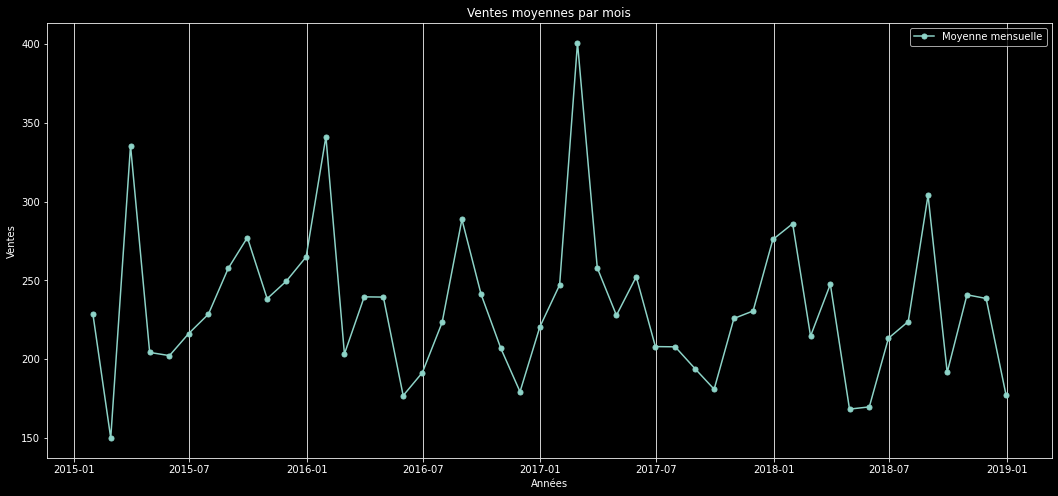

In [444]:

y = data_m['Sales']
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(y,marker = 'o',markersize='5',linestyle='-',label = 'Moyenne mensuelle')
ax.set_xlabel('Années')
ax.set_ylabel('Ventes')
ax.set_title('Ventes moyennes par mois')
ax.grid(axis='x')
ax.legend();


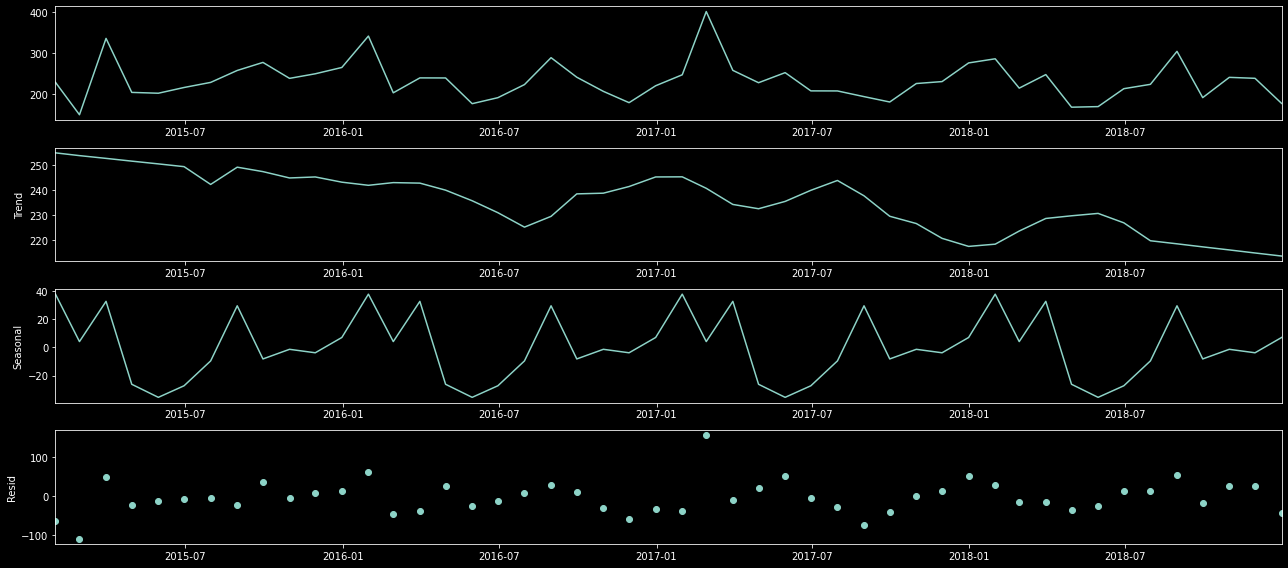

In [446]:
data_m_dec=seasonal_decompose(data_m,model='additive', extrapolate_trend='freq')
data_m_dec.plot();

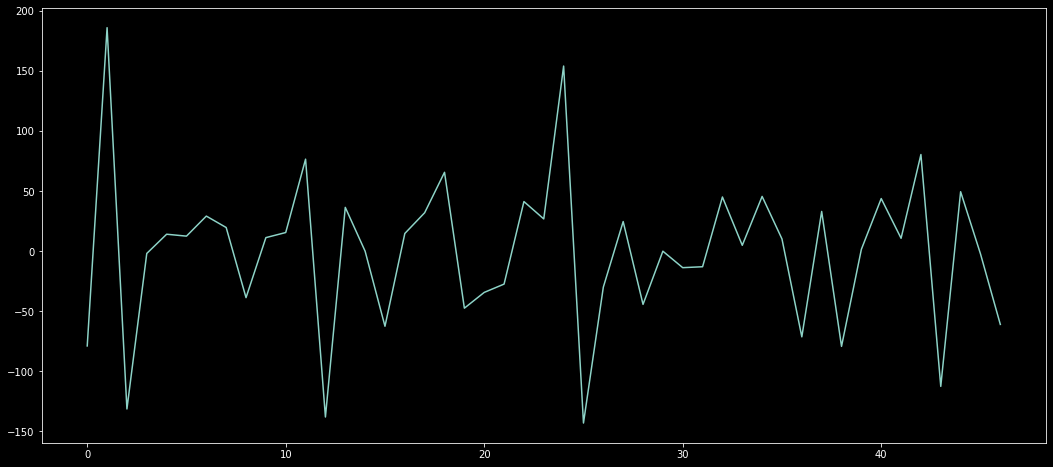

In [447]:
X = data_m.values
diff = list()
for i in range(1, len(X)):
	value = X[i] - X[i - 1]
	diff.append(value)
plt.plot(diff)
plt.show()

##### Test de saisonnalité

In [448]:
from kats.detectors.seasonality import FFTDetector
from kats.detectors.outlier import OutlierDetector
from kats.consts import TimeSeriesData


In [449]:
data_m['time']=data_m.index
data_m_ts= TimeSeriesData(data_m)
data_m_ts

,time,Sales
0,2015-01-31,228.795667
1,2015-02-28,149.862905
2,2015-03-31,335.575727
3,2015-04-30,204.215008
4,2015-05-31,202.195137
5,2015-06-30,216.158034
6,2015-07-31,228.536091
7,2015-08-31,257.581141
8,2015-09-30,277.127730
9,2015-10-31,238.358255


In [450]:
fft_detector = FFTDetector(data_m_ts)
fft_detector.detector()

{'seasonality_presence': False, 'seasonalities': []}

##### Points abérants

In [451]:

outlier_detector = OutlierDetector(data_m_ts, "additive")

outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[]

In [452]:
data_m_ts_outliers_interpolated = outlier_detector.remover(interpolate=True)


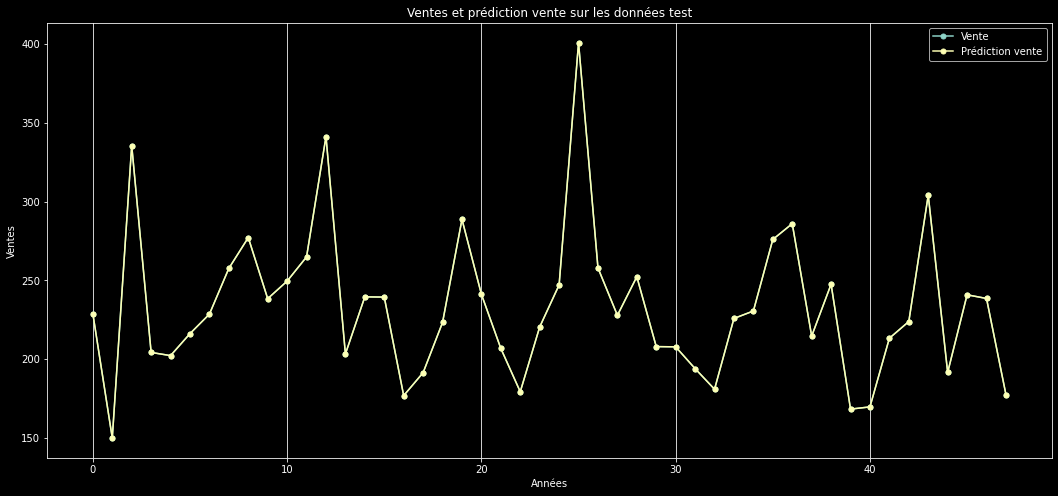

In [453]:
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(data_m_ts.to_dataframe()["Sales"],marker = 'o',markersize='5',linestyle='-',label = 'Vente')
ax.plot(data_m_ts_outliers_interpolated.to_dataframe()["y_0"],marker = 'o',markersize='5',linestyle='-',label = 'Prédiction vente')

ax.set_xlabel('Années')
ax.set_ylabel('Ventes')
ax.set_title('Ventes et prédiction vente sur les données test')
ax.grid(axis='x')
ax.legend()

In [454]:
data_m=data_m_ts_outliers_interpolated.to_dataframe()
data_m.rename(columns={'y_0' : 'sales'},inplace = True)
data_m 

,time,sales
0,2015-01-31,228.795667
1,2015-02-28,149.862905
2,2015-03-31,335.575727
3,2015-04-30,204.215008
4,2015-05-31,202.195137
5,2015-06-30,216.158034
6,2015-07-31,228.536091
7,2015-08-31,257.581141
8,2015-09-30,277.127730
9,2015-10-31,238.358255


On reteste la saisonnalité sans point abbérhant 

In [455]:
data_m_ts= TimeSeriesData(data_m)
fft_detector = FFTDetector(data_m_ts)
fft_detector.detector()

{'seasonality_presence': False, 'seasonalities': []}

In [456]:
data_m.set_index(['time'],inplace=True)
data_m

,sales
time,
2015-01-31,228.795667
2015-02-28,149.862905
2015-03-31,335.575727
2015-04-30,204.215008
2015-05-31,202.195137
2015-06-30,216.158034
2015-07-31,228.536091
2015-08-31,257.581141
2015-09-30,277.127730


In [457]:
# découpage app/test
train_size = data_m.shape[0]//4
data_m_train = data_m.iloc[train_size:]
data_m_test = data_m.iloc[:train_size]


In [459]:
# Normalisation des données entre 0 et 1
sc = MinMaxScaler(feature_range = (0, 1))
data_m_train_normalise = pd.DataFrame(sc.fit_transform(data_m_train))[0]
data_m_test_normalise = pd.DataFrame(sc.fit_transform(data_m_test))[0]



In [460]:

#Construire de X_train et Y_train 
#nb_features :nombre de prédicteurs
X_train = []
Y_train = []
nb_features=5
n_train = data_m_train.shape[0]
for i in range(nb_features,n_train ):
    X_train.append(data_m_train_normalise[i-nb_features:i].to_numpy())
    Y_train.append(data_m_train_normalise[i])
X_train=np.array(X_train)
Y_train=np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(31, 5, 1)

In [461]:
#Construire de X_train et Y_train 
#nb_features :nombre de prédicteurs
X_test = []
Y_test = []
nb_features=5
n_test = data_m_test.shape[0]
for i in range(nb_features,n_test ):
    X_test.append(data_m_test_normalise[i-nb_features:i].to_numpy())
    Y_test.append(data_m_test_normalise[i])
X_test=np.array(X_test)
Y_test=np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(7, 5, 1)

In [462]:

regressor = Sequential()
# Le modèle séquentiel est une pile linéaire de couches.


In [463]:

# units : correspond à la sortie de chaque couche
# on construit 5 couches LSTM avec 50
# return_sequences = True pour retourner les valeurs des couches cachées importante pour les couches suivantes
# regressor.add(Dropout(0.2)) utiliser qu'une partie des données train pour l'activation, permet d'éviter le surapprentissage
#regressor.add(LSTM(units = 50)) plus besoin de retourner les valeurs intermediaires car la dernière couche
# est une couche simple à une sortie qui donne la prédiction 


regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))
regressor.add(Dense(units = 1))

optimizer : Il peut s’agir d’un optimiseur défini par son appellation, par exemple rmsprop ou adagrad , ou d’une instance de la classe Optimizer.

In [464]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, Y_train, epochs = 200, batch_size = 32)


Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1117
Epoch 2/200
1/1 [==============================] - 0s 9ms/step - loss: 0.1043
Epoch 3/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0971
Epoch 4/200
1/1 [==============================] - 0s 11ms/step - loss: 0.0901
Epoch 5/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0824
Epoch 6/200
1/1 [==============================] - 0s 13ms/step - loss: 0.0741
Epoch 7/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0678
Epoch 8/200
1/1 [==============================] - 0s 10ms/step - loss: 0.0617
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 0.0527
Epoch 10/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0493
Epoch 11/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0443
Epoch 12/200
1/1 [==============================] - 0s 13ms/step - loss: 0.0426
Epoch 13/200
1/1 [==============================] - 

In [466]:
predictions_ventes = regressor.predict(X_test)
predictions_ventes = sc.inverse_transform(predictions_ventes)

In [467]:
predictions_ventes_train = regressor.predict(X_train)
predictions_ventes_train = sc.inverse_transform(predictions_ventes_train)

In [468]:
Y_test=Y_test.reshape(-1, 1)
Y_test_non_normalise=sc.inverse_transform(Y_test)


In [469]:
Y_train=Y_train.reshape(-1, 1)
Y_train_non_normalise=sc.inverse_transform(Y_train)


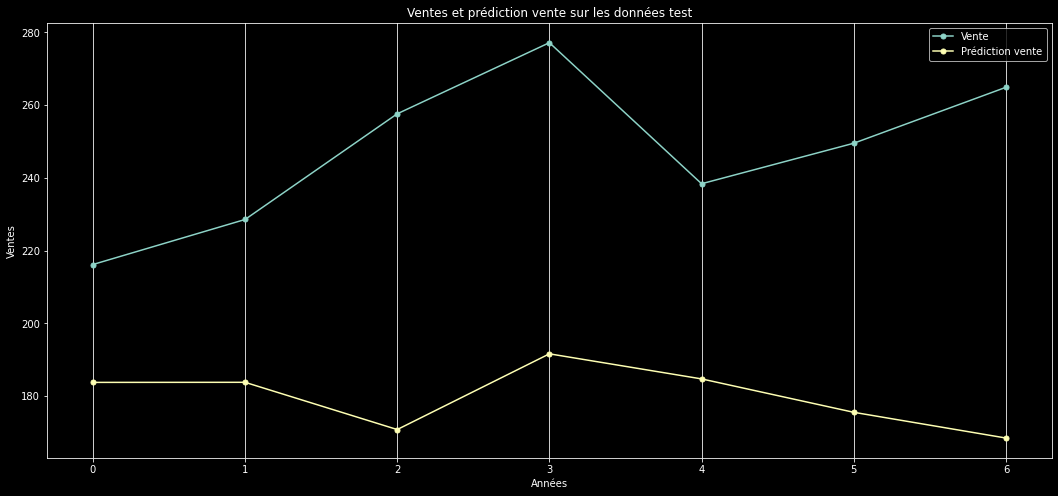

In [470]:
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(Y_test_non_normalise,marker = 'o',markersize='5',linestyle='-',label = 'Vente')
ax.plot(predictions_ventes,marker = 'o',markersize='5',linestyle='-',label = 'Prédiction vente')

ax.set_xlabel('Années')
ax.set_ylabel('Ventes')
ax.set_title('Ventes et prédiction vente sur les données test')
ax.grid(axis='x')
ax.legend()

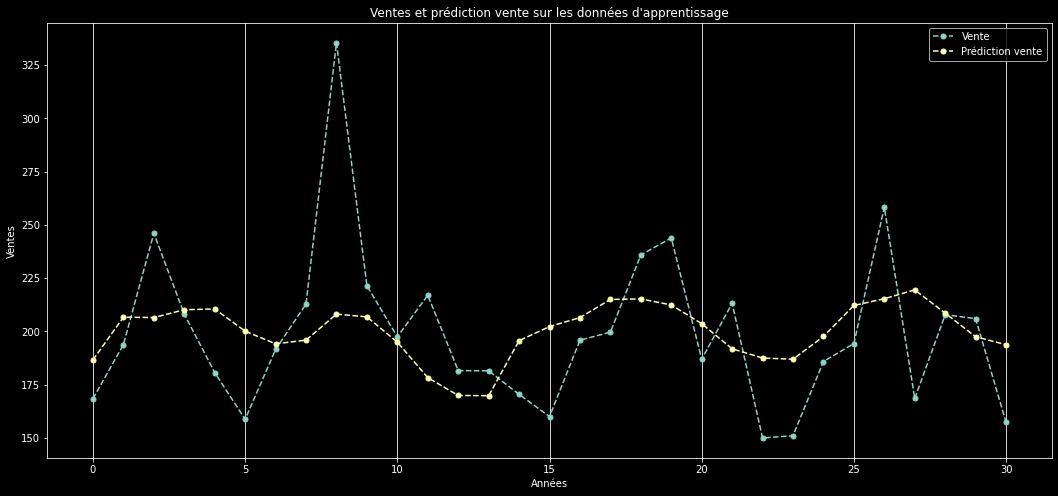

In [471]:
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(Y_train_non_normalise,marker = 'o',markersize='5',linestyle='--',label = 'Vente')
ax.plot(predictions_ventes_train,marker = 'o',markersize='5',linestyle='--',label = 'Prédiction vente')

ax.set_xlabel('Années')
ax.set_ylabel('Ventes')
ax.set_title('Ventes et prédiction vente sur les données d\'apprentissage')
ax.grid(axis='x')
ax.legend();

In [472]:
mse = mean_squared_error(Y_test_non_normalise,predictions_ventes)
rsme = np.sqrt(mse)

print(f"La racine de l'erreur quadratique moyenne du modèle LSTM est de : {rsme}")

La racine de l'erreur quadratique moyenne du modèle LSTM est de : 71.24686346057672


On constate pour le moment que notre modèle ayant la plus faible rsme est le modèle de réseaux de neurones

## Conclusion